# Workshop 2: Spatial & Geometry Operations on Vector data

Programación SIG  2025-1S    
Universidad Nacional de Colombia    
Alicia Arévalo Robinson

- Workshop extracted from [Link](https://github.com/lccastillov/prog_sig_2025_1/blob/main/Workshop6_SpatialOpertaions_Vector_Data.ipynb)  
- GitHub Repository: https://github.com/aliciaarevalor/PS

This project consists of carrying out two multicriteria analyses for the municipalities of the Orinoquia region. The criteria to consider are:

1. Number of IDEAM stations
2. Density of primary roads 
3. Population 
4. Proximity to primary roads
5. Simple drainage networks

The first analysis (Level 1) takes into account the first four criteria and, based on a weight assigned to each, obtains a weighted value for each municipality. From this level, the municipality with the highest value is selected and used for the next analysis. The second part of the study (Level 2) is a spatial analysis that identifies the best area to locate a new IDEAM station, considering criteria 1, 4, and 5.  

Data of primary roads were extracted from https://inviasopendata-invias.opendata.arcgis.com/, population from `municipios_colombia.shp`, IDEAM stations from `Catalogo_Estaciones_IDEAM.csv`, and simple drainage networks from https://www.datos.gov.co/en/dataset/Drenaje-Sencillo/68v7-gsra/about_data

## 0. Modules 🗒️

In [9]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import contextily as cx
from pathlib import Path
from shapely.geometry import Point

import numpy as np
import shapely
from shapely import affinity

## 1. Input data 📂

#### Read files path

In [10]:
# Main folder
root_folder = "./data"

muni_path = root_folder + "/municipios_colombia.shp"

eva_path = root_folder + "/Evaluaciones_Agropecuarias_Municipales_EVA.csv"

ideam_path = root_folder + "/Catalogo_Estaciones_IDEAM.csv"

precip_path = root_folder + "/precipitacion.csv"

road_path = root_folder + "/RedVial.shp"

drainage_path = root_folder + "/Drenaje_Sencillo.geojson"

#### Read CSV files

In [11]:
eva = pd.read_csv(eva_path, encoding='utf-8')
ideam = pd.read_csv(ideam_path,encoding='utf-8')  
precip= pd.read_csv(precip_path, encoding='utf-8')

#### Read GeoDataFrames

In [12]:
# Read and project to EPSG:9377
muni = gpd.read_file(muni_path).to_crs(epsg=9377)
road = gpd.read_file(road_path).to_crs(epsg=9377)
drainage = gpd.read_file(drainage_path).to_crs(epsg=9377)

## 2. Data Preprocessing 🧹

### 2.1 `ideam`    

- Read location of IDEAM stations transforming coordinates to points. Then, read `ideam` as a GeoDataFrame  
- Spatial join `ideam` with `muni` to have geometry municipalities in ideam. This step is for plotting later.  


##### Read `ideam` as a GeoDataGrame

In [13]:
# Convert string coordinates to Points using string manipulation
ideam['geometry'] = ideam['Ubicación'].apply(
    lambda x: Point(
        float(x.strip('()').split(',')[1]),  # longitude
        float(x.strip('()').split(',')[0])   # latitude
    )
)

# Create GeoDataFrame
ideam_gdf = gpd.GeoDataFrame(
    ideam,
    geometry='geometry',
    crs="EPSG:4326"  
)

# Convert to EPSG:9377
ideam_gdf = ideam_gdf.to_crs(9377)

##### Spatial join each station to its municipality (`gpd.sjoin`)

Due that we will join `ideam_gdf` with `muni`, we need to have both GeoDataFrames with the same column for **Municipio**.  
For this, we rename the column **Municipio** to **MPIO_CNMBR** in `ideam_gdf`, and transform all strings to uppercase text. 

In [14]:
ideam_gdf = ideam_gdf.rename(columns={'Municipio': 'MPIO_CNMBR'})
ideam_gdf['MPIO_CNMBR'] = ideam_gdf['MPIO_CNMBR'].str.upper()

##### Join `ideam_gdf` with `muni` using `gpd.sjoin`

In [15]:
stations_with_muni = gpd.sjoin(
    ideam_gdf,   
    muni,         
    how='inner',
    predicate='within'  
)

stations_with_muni

,Codigo,Nombre,Categoria,Estado,Departamento,MPIO_CNMBR_left,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,...,STP34_9_ED,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,IPIALES,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,...,2163.0,40870.0,38984.0,12954.0,1333.0,3365.0,1157.0,2.849864,0.127272,52356
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,CONTADERO,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,...,212.0,3200.0,2084.0,407.0,47.0,215.0,66.0,0.327929,0.003498,52210
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,TÚQUERRES,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,...,960.0,20799.0,13139.0,3412.0,477.0,1682.0,478.0,0.755709,0.017506,52838
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,MOCOA,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,PUERTO NARIÑO,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,...,41.0,2512.0,3012.0,429.0,39.0,266.0,726.0,1.968859,0.122363,91540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,4401700167,NIVEL SANGOYACO GARGANTA,Limnimétrica,Activa,Putumayo,MOCOA,"(1.15872222, -76.67080556)",761,2020-02-25,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001
8969,4401700168,NIVEL MULATO PALMERAS,Limnimétrica,Activa,Putumayo,MOCOA,"(1.15638889, -76.69027778)",966,2020-02-25,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001
8970,4401700172,NIVEL MOCOA PISCIKART,Limnimétrica,Activa,Putumayo,VILLAGARZÓN,"(1.03964167, -76.61091944)",408,2020-02-25,NaN,...,303.0,8393.0,8784.0,2000.0,266.0,851.0,431.0,1.928017,0.113257,86885
8971,4401700173,NIVEL RUMIYACO LAGARTO,Limnimétrica,Activa,Putumayo,MOCOA,"(1.119225, -76.67045)",647,2020-02-25,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001


`gpd.sjoin()` returns a GeoDataFrame with the geometry of the left DataFrame, so it is necessary to add a column with the geometry of municipalities.

In [16]:
# Add the municipality geometry as a new column
stations_with_muni['muni_geometry'] = stations_with_muni.apply(
    lambda row: muni.loc[row['index_right'], 'geometry'] if pd.notnull(row['index_right']) else None,
    axis=1
)

# Keep relevant columns
stations_with_muni = (stations_with_muni.rename(columns={"MPIO_CNMBR_left": "MPIO_CNMBR"}))
stations_with_muni=stations_with_muni[['Codigo','Nombre','Departamento','MPIO_CNMBR','MPIO_CDPMP','geometry','muni_geometry','DPTO_CCDGO']]
stations_with_muni.head()

,Codigo,Nombre,Departamento,MPIO_CNMBR,MPIO_CDPMP,geometry,muni_geometry,DPTO_CCDGO
0,52057100,RUMICHACA - AUT [52057100],Nariño,IPIALES,52356,POINT (4.48e+06 1.65e+06),"POLYGON ((4.49e+06 1.66e+06, 4.49e+06 1.66e+06...",52
1,52055170,LA JOSEFINA - AUT [52055170],Nariño,CONTADERO,52210,POINT (4.5e+06 1.66e+06),"POLYGON ((4.49e+06 1.66e+06, 4.49e+06 1.66e+06...",52
2,52055220,EL PARAISO - AUT [52055220],Nariño,TÚQUERRES,52838,POINT (4.48e+06 1.68e+06),"POLYGON ((4.49e+06 1.7e+06, 4.49e+06 1.7e+06, ...",52
3,44015070,EL PEPINO - AUT [44015070],Putumayo,MOCOA,86001,POINT (4.59e+06 1.68e+06),"POLYGON ((4.59e+06 1.72e+06, 4.59e+06 1.72e+06...",86
4,48015040,PUERTO NARINO - AUT [48015040],Amazonas,PUERTO NARIÑO,91540,POINT (5.29e+06 1.14e+06),"POLYGON ((5.29e+06 1.15e+06, 5.29e+06 1.15e+06...",91


### 2.2 Get departments names and geometries

##### From `muni`, get departments geometry dissolving the GeoDataFrame by **DPTO_CCDGO**

In [17]:
departments = muni.dissolve(by='DPTO_CCDGO', as_index=False)
departments=departments[['DPTO_CCDGO', 'geometry']]

##### Merge `departments` with `stations_with_muni` to get the name of each department by their code (**DPTO_CCDGO**)

In [ ]:
departments_with_name = departments.merge(
    stations_with_muni,
    how='left',
    on='DPTO_CCDGO',
    validate='one_to_many',     
)

departments_with_name=departments_with_name[['DPTO_CCDGO','Departamento','geometry_x']].drop_duplicates(subset='DPTO_CCDGO')
departments_with_name=departments_with_name.set_geometry('geometry_x')
departments_with_name.head()

,DPTO_CCDGO,Departamento,geometry_x
0,05,Antioquia,"POLYGON ((4.76e+06 2.17e+06, 4.76e+06 2.17e+06..."
1215,08,Atlantico,"POLYGON ((4.8e+06 2.7e+06, 4.8e+06 2.7e+06, 4...."
1325,11,Bogotá,"POLYGON ((4.88e+06 2.09e+06, 4.88e+06 2.09e+06..."
1652,13,Bolívar,"MULTIPOLYGON (((4.9e+06 2.38e+06, 4.9e+06 2.38..."
1963,15,Boyacá,"POLYGON ((5e+06 2.11e+06, 5e+06 2.11e+06, 5e+0..."


Select departments from Orinoquia Region

In [19]:
ori=departments_with_name[departments_with_name["Departamento"].isin(["Arauca", "Casanare", "Vichada", "Meta"])].copy()

Extract municipalities from Orinoquia region

In [20]:
ori_muni = muni[muni["DPTO_CCDGO"].isin(ori["DPTO_CCDGO"])] 
ori_muni['area_km2'] = ori_muni.geometry.area / 1e6
ori_muni = ori_muni[['DPTO_CCDGO', 'MPIO_CNMBR','area_km2', 'geometry']]
ori_muni

c:\Users\VICTUS\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry
185,99,SANTA ROSALÍA,3884.706067,"POLYGON ((5.26e+06 2.15e+06, 5.26e+06 2.15e+06..."
186,99,PUERTO CARREÑO,12142.361360,"POLYGON ((5.57e+06 2.26e+06, 5.57e+06 2.26e+06..."
187,99,LA PRIMAVERA,18286.358754,"POLYGON ((5.44e+06 2.25e+06, 5.44e+06 2.25e+06..."
188,99,CUMARIBO,65319.247163,"POLYGON ((5.5e+06 2.17e+06, 5.5e+06 2.17e+06, ..."
189,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06..."
190,85,AGUAZUL,1439.265160,"POLYGON ((5.05e+06 2.15e+06, 5.05e+06 2.15e+06..."
191,85,CHÁMEZA,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06..."
192,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06..."
193,85,MANÍ,3745.281360,"POLYGON ((5.07e+06 2.12e+06, 5.07e+06 2.12e+06..."
194,85,MONTERREY,777.573425,"POLYGON ((5.01e+06 2.11e+06, 5.01e+06 2.11e+06..."


### 2.3 `muni`

Create a column of area of municipalities in km2

In [21]:
muni['area_km2'] = ori_muni.geometry.area / 1e6

##### Adjust `eva` and `muni` columns to be able to merge later

In [22]:
# EVA table, rename code column
eva = (eva.rename(columns={"CÓD. MUN.": "cod_mun"}))

eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

#Homogenise municipalities codes
muni["MPIO_CCDGO"] = muni["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]     = eva["cod_mun"].astype(str).str.zfill(5)

print(f"{len(muni):,} municipalities • {len(ideam):,} stations • "
      f"{len(eva):,} EVA rows")

1,122 municipalities • 8,973 stations • 206,068 EVA rows


##### Merge `muni` and `eva`

This merge is done to work with `eva` as a GeoDataFrame with the geometries of the municipalities

In [23]:
muni_eva = muni.merge(
    eva,
    how='left',                 
    left_on='MPIO_CDPMP',       
    right_on='cod_mun',            
    indicator=True,             
    validate='one_to_many',     
    suffixes=('', '_eva')       
)

### 2.4 Validate CRS of GeoDataFrames 

In [24]:
print("muni CRS:", muni.crs)       
print("ideam CRS:", ideam_gdf.crs)
print("road CRS:", road.crs)   
print("eva CRS:", muni_eva.crs)      
print("departments CRS:", departments_with_name.crs) 

muni CRS: EPSG:9377
ideam CRS: EPSG:9377
road CRS: EPSG:9377
eva CRS: EPSG:9377
departments CRS: EPSG:9377


## 3. Data analysis 📊

### **Level 1: Municipality selection**

The four criteria considered for this level are: Number of IDEAM stations per municipality, Primary roads density, Population density, and Proximity to primary roads.

#### **Number of IDEAM stations per municipalities**

Count number of stations in each municipality

In [25]:
station_counts = stations_with_muni.groupby('MPIO_CNMBR').size().reset_index(name='station_count')

Merge with `ori_muni`

In [26]:
ori_station_counts = ori_muni.merge(station_counts, on='MPIO_CNMBR', how='left')

# Fill municipalities with no stations with 0
ori_station_counts['station_count'] = ori_station_counts['station_count'].fillna(0).astype(int)

ori_station_counts = ori_station_counts[['DPTO_CCDGO','MPIO_CNMBR','station_count','area_km2','geometry']]

Stations density

In [129]:
ori_station_counts['stations_density']= ori_station_counts['station_count'] / ori_station_counts['area_km2']
ori_station_counts = ori_station_counts.sort_values(by="stations_density", ascending=False)
ori_station_counts.head()

,DPTO_CCDGO,MPIO_CNMBR,station_count,area_km2,geometry,stations_density
37,50,EL CALVARIO,12,277.439283,"POLYGON ((4.92e+06 2.05e+06, 4.92e+06 2.05e+06...",0.043253
30,50,VILLAVICENCIO,28,1283.784072,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",0.021811
6,85,CHÁMEZA,6,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06...",0.019176
53,50,SAN JUANITO,3,236.990181,"POLYGON ((4.93e+06 2.06e+06, 4.93e+06 2.06e+06...",0.012659
34,50,CASTILLA LA NUEVA,6,513.862876,"POLYGON ((4.92e+06 1.99e+06, 4.92e+06 1.99e+06...",0.011676


#### **Primary roads density**

Calculate length of roads in km

In [128]:
road['length_m'] = road.geometry.length
road['length_km'] = road['length_m'] / 1000

Clip roads to each municipality

In [127]:
road_clip = gpd.overlay(road, ori_muni, how='intersection')

Sum road length by municipality

In [126]:
road_length_by_muni = road_clip.groupby('MPIO_CNMBR')['length_km'].sum().reset_index()
road_length_by_muni.rename(columns={'length_km': 'total_road_km'}, inplace=True)

Merge and compute road density

In [125]:
# Merge road lengths into municipality dataframe
road_muni = ori_muni.merge(road_length_by_muni, on='MPIO_CNMBR', how='right').copy()

# Calculate road density
road_muni['road_density'] = road_muni['total_road_km'] / road_muni['area_km2']
road_muni = road_muni.sort_values(by="road_density", ascending=False)
road_muni.head()

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,total_road_km,road_density
9,50,GRANADA,347.802390,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",294.116886,0.845644
13,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06...",122.961939,0.616600
30,85,SÁCAMA,311.467073,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",154.453490,0.495890
26,85,SABANALARGA,400.158205,"POLYGON ((5e+06 2.11e+06, 5e+06 2.11e+06, 5e+0...",143.259185,0.358006
25,50,RESTREPO,364.517064,"POLYGON ((4.94e+06 2.05e+06, 4.94e+06 2.05e+06...",108.611911,0.297961


#### **Population density**

Extract population data of each municipality from `muni`

In [130]:
ori_population = muni[muni["DPTO_CCDGO"].isin(ori["DPTO_CCDGO"])]
ori_population = ori_population[['DPTO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'area_km2','STP27_PERS', 'geometry']]

Population density

Calculate population density diving population by area of municipality in km2

In [33]:
ori_population['pop_density'] = ori_population['STP27_PERS'] / ori_population['area_km2'] 
ori_population = ori_population.sort_values(by="pop_density", ascending=False)   
ori_population.head()

,DPTO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,area_km2,STP27_PERS,geometry,pop_density
909,50,VILLAVICENCIO,50001,1283.784072,451212.0,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",351.470321
920,50,GRANADA,50313,347.802390,64932.0,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",186.692219
910,50,ACACÍAS,50006,1122.077275,78199.0,"POLYGON ((4.91e+06 2.02e+06, 4.91e+06 2.02e+06...",69.691279
189,85,YOPAL,85001,2476.887302,156942.0,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06...",63.362592
635,81,SARAVENA,81736,942.587362,52884.0,"POLYGON ((5.14e+06 2.34e+06, 5.14e+06 2.34e+06...",56.105144


#### **Proximity to primary roads**

This step calculates thepercentage of municipality area within 1 km of roads buffer

Create a buffer of 1 km around roads

In [131]:
road_buffer=road.copy()
road_buffer['geometry_1000'] = road_buffer.geometry.buffer(1000)
road_buffer = road_buffer[['length_km', 'geometry_1000']]
road_buffer=road_buffer.set_geometry("geometry_1000")

,length_km,geometry_1000
0,13.015786,"POLYGON ((4.92e+06 2.48e+06, 4.92e+06 2.48e+06..."
1,3.326309,"POLYGON ((4.92e+06 2.47e+06, 4.92e+06 2.47e+06..."
2,1.397585,"POLYGON ((4.93e+06 2.47e+06, 4.93e+06 2.47e+06..."
3,1.904667,"POLYGON ((4.93e+06 2.47e+06, 4.93e+06 2.47e+06..."
4,3.437777,"POLYGON ((4.95e+06 2.43e+06, 4.95e+06 2.43e+06..."
...,...,...
648,13.191896,"POLYGON ((5e+06 2.2e+06, 5e+06 2.2e+06, 5e+06 ..."
649,0.078243,"POLYGON ((4.81e+06 2.76e+06, 4.81e+06 2.76e+06..."
650,31.300031,"POLYGON ((4.81e+06 2.76e+06, 4.81e+06 2.76e+06..."
651,0.086517,"POLYGON ((5e+06 2.2e+06, 5e+06 2.2e+06, 5e+06 ..."


Overlay `ori_muni` and `road_buffer` to get roads located in our region of interest

In [133]:
buffer_muni = gpd.overlay(ori_muni, road_buffer, how='intersection')

% of Municipality area within buffer

- Dissolve `buffer_muni` to get information of roads by munincipalities

In [ ]:
buffer_muni_dissolved = buffer_muni.dissolve(by="MPIO_CNMBR")

,geometry,DPTO_CCDGO,area_km2,length_km
MPIO_CNMBR,,,,
ACACÍAS,"MULTIPOLYGON (((4.91e+06 2.01e+06, 4.91e+06 2....",50,1122.077275,14.341071
AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989
ARAUCA,"POLYGON ((5.22e+06 2.31e+06, 5.22e+06 2.31e+06...",81,5767.334096,130.450941
ARAUQUITA,"MULTIPOLYGON (((5.22e+06 2.31e+06, 5.22e+06 2....",81,3037.475142,130.450941
BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022
CUBARRAL,"POLYGON ((4.92e+06 1.98e+06, 4.92e+06 1.98e+06...",50,1156.421578,69.988672
CUMARAL,"POLYGON ((4.95e+06 2.03e+06, 4.95e+06 2.03e+06...",50,624.000798,106.832397
FORTUL,"POLYGON ((5.15e+06 2.29e+06, 5.15e+06 2.29e+06...",81,1155.454615,132.105237
FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909


- Calculate area of roads buffers

In [37]:
buffer_muni_dissolved['buffer_area_km2'] = buffer_muni_dissolved.geometry.area / 1e6
buffer_muni_dissolved

,geometry,DPTO_CCDGO,area_km2,length_km,buffer_area_km2
MPIO_CNMBR,,,,,
ACACÍAS,"MULTIPOLYGON (((4.91e+06 2.01e+06, 4.91e+06 2....",50,1122.077275,14.341071,39.442361
AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989,122.968757
ARAUCA,"POLYGON ((5.22e+06 2.31e+06, 5.22e+06 2.31e+06...",81,5767.334096,130.450941,125.954280
ARAUQUITA,"MULTIPOLYGON (((5.22e+06 2.31e+06, 5.22e+06 2....",81,3037.475142,130.450941,121.954766
BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022,34.536067
CUBARRAL,"POLYGON ((4.92e+06 1.98e+06, 4.92e+06 1.98e+06...",50,1156.421578,69.988672,7.591479
CUMARAL,"POLYGON ((4.95e+06 2.03e+06, 4.95e+06 2.03e+06...",50,624.000798,106.832397,33.545981
FORTUL,"POLYGON ((5.15e+06 2.29e+06, 5.15e+06 2.29e+06...",81,1155.454615,132.105237,40.309898
FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909,81.425372


- Calculate percentage of municipality area inside roads buffers

In [38]:
buffer_muni_dissolved['area_in_buffer'] = (buffer_muni_dissolved['buffer_area_km2'] / buffer_muni_dissolved['area_km2']) * 100
buffer_muni_dissolved = buffer_muni_dissolved.sort_values(by="area_in_buffer", ascending=False)
buffer_muni_dissolved = buffer_muni_dissolved.reset_index()
buffer_muni_dissolved

,MPIO_CNMBR,geometry,DPTO_CCDGO,area_km2,length_km,buffer_area_km2,area_in_buffer
0,GRANADA,"POLYGON ((4.92e+06 1.94e+06, 4.92e+06 1.94e+06...",50,347.802390,69.988672,81.870508,23.539375
1,SABANALARGA,"POLYGON ((5e+06 2.09e+06, 5e+06 2.09e+06, 5e+0...",85,400.158205,50.685022,67.711106,16.921084
2,SÁCAMA,"MULTIPOLYGON (((5.07e+06 2.22e+06, 5.07e+06 2....",85,311.467073,122.961939,51.731134,16.608861
3,VILLAVICENCIO,"MULTIPOLYGON (((4.92e+06 2e+06, 4.92e+06 2e+06...",50,1283.784072,14.341071,194.755055,15.170390
4,FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909,81.425372,14.282658
5,MONTERREY,"POLYGON ((5.03e+06 2.09e+06, 5.03e+06 2.09e+06...",85,777.573425,50.685022,71.756673,9.228283
6,LA SALINA,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",85,199.419246,122.961939,17.385315,8.717973
7,BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022,34.536067,8.569127
8,AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989,122.968757,8.543857
9,SARAVENA,"POLYGON ((5.14e+06 2.31e+06, 5.14e+06 2.31e+06...",81,942.587362,148.618949,72.499073,7.691496


Plot Roads (with 1 km buffer) in Orinoquia

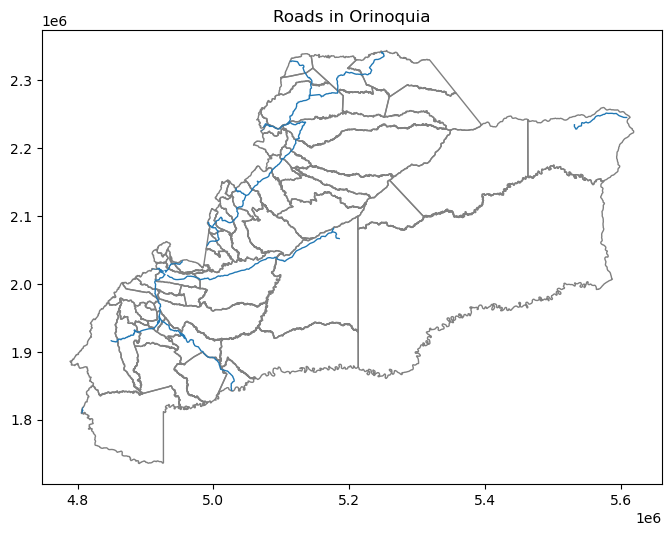

In [39]:
ax = ori_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
buffer_muni_dissolved.plot(ax=ax)
plt.title("Roads in Orinoquia")
plt.show()

#### **Weighted criteria**

In [40]:
print(len(ori_muni), "municipalities in Orinoquia")
ori_muni

59 municipalities in Orinoquia


,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry
185,99,SANTA ROSALÍA,3884.706067,"POLYGON ((5.26e+06 2.15e+06, 5.26e+06 2.15e+06..."
186,99,PUERTO CARREÑO,12142.361360,"POLYGON ((5.57e+06 2.26e+06, 5.57e+06 2.26e+06..."
187,99,LA PRIMAVERA,18286.358754,"POLYGON ((5.44e+06 2.25e+06, 5.44e+06 2.25e+06..."
188,99,CUMARIBO,65319.247163,"POLYGON ((5.5e+06 2.17e+06, 5.5e+06 2.17e+06, ..."
189,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06..."
190,85,AGUAZUL,1439.265160,"POLYGON ((5.05e+06 2.15e+06, 5.05e+06 2.15e+06..."
191,85,CHÁMEZA,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06..."
192,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06..."
193,85,MANÍ,3745.281360,"POLYGON ((5.07e+06 2.12e+06, 5.07e+06 2.12e+06..."
194,85,MONTERREY,777.573425,"POLYGON ((5.01e+06 2.11e+06, 5.01e+06 2.11e+06..."


In [41]:
print(len(buffer_muni_dissolved))
buffer_muni_dissolved

41


,MPIO_CNMBR,geometry,DPTO_CCDGO,area_km2,length_km,buffer_area_km2,area_in_buffer
0,GRANADA,"POLYGON ((4.92e+06 1.94e+06, 4.92e+06 1.94e+06...",50,347.802390,69.988672,81.870508,23.539375
1,SABANALARGA,"POLYGON ((5e+06 2.09e+06, 5e+06 2.09e+06, 5e+0...",85,400.158205,50.685022,67.711106,16.921084
2,SÁCAMA,"MULTIPOLYGON (((5.07e+06 2.22e+06, 5.07e+06 2....",85,311.467073,122.961939,51.731134,16.608861
3,VILLAVICENCIO,"MULTIPOLYGON (((4.92e+06 2e+06, 4.92e+06 2e+06...",50,1283.784072,14.341071,194.755055,15.170390
4,FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909,81.425372,14.282658
5,MONTERREY,"POLYGON ((5.03e+06 2.09e+06, 5.03e+06 2.09e+06...",85,777.573425,50.685022,71.756673,9.228283
6,LA SALINA,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",85,199.419246,122.961939,17.385315,8.717973
7,BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022,34.536067,8.569127
8,AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989,122.968757,8.543857
9,SARAVENA,"POLYGON ((5.14e+06 2.31e+06, 5.14e+06 2.31e+06...",81,942.587362,148.618949,72.499073,7.691496


In [42]:
ori_muni_final = ori_muni.merge(ori_station_counts[['MPIO_CNMBR','stations_density']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(road_muni[['MPIO_CNMBR','road_density']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(ori_population[['MPIO_CNMBR','pop_density']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(buffer_muni_dissolved[['MPIO_CNMBR','area_in_buffer']], on='MPIO_CNMBR', how='left')
ori_muni_final

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,stations_density,road_density,pop_density,area_in_buffer
0,99,SANTA ROSALÍA,3884.706067,"POLYGON ((5.26e+06 2.15e+06, 5.26e+06 2.15e+06...",0.001030,NaN,1.036372,NaN
1,99,PUERTO CARREÑO,12142.361360,"POLYGON ((5.57e+06 2.26e+06, 5.57e+06 2.26e+06...",0.000988,0.007926,1.629667,1.606865
2,99,LA PRIMAVERA,18286.358754,"POLYGON ((5.44e+06 2.25e+06, 5.44e+06 2.25e+06...",0.000602,NaN,0.529903,NaN
3,99,CUMARIBO,65319.247163,"POLYGON ((5.5e+06 2.17e+06, 5.5e+06 2.17e+06, ...",0.000337,NaN,0.660418,NaN
4,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06...",0.003230,0.078618,63.362592,3.687852
5,85,AGUAZUL,1439.265160,"POLYGON ((5.05e+06 2.15e+06, 5.05e+06 2.15e+06...",0.004864,0.141191,23.234079,8.543857
6,85,CHÁMEZA,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06...",0.019176,NaN,6.420728,NaN
7,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06...",0.000000,0.616600,6.152867,8.717973
8,85,MANÍ,3745.281360,"POLYGON ((5.07e+06 2.12e+06, 5.07e+06 2.12e+06...",0.000000,NaN,3.548732,NaN
9,85,MONTERREY,777.573425,"POLYGON ((5.01e+06 2.11e+06, 5.01e+06 2.11e+06...",0.002572,0.196652,19.069582,9.228283


- Apply a score for each criteria

In [43]:
ori_muni_final['final_score']= (
    0.25 * ori_muni_final['stations_density'] +
    0.25 * ori_muni_final['road_density'] +
    0.25 * ori_muni_final['pop_density'] +
    0.25 * ori_muni_final['area_in_buffer'])

ori_muni_final= ori_muni_final.sort_values(by="final_score", ascending=False)
ori_muni_final.head()

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,stations_density,road_density,pop_density,area_in_buffer,final_score
30,50,VILLAVICENCIO,1283.784072,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",0.021811,0.292006,351.470321,15.170390,91.738632
41,50,GRANADA,347.802390,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",0.000000,0.845644,186.692219,23.539375,52.769309
31,50,ACACÍAS,1122.077275,"POLYGON ((4.91e+06 2.02e+06, 4.91e+06 2.02e+06...",0.009803,0.062971,69.691279,3.515120,18.319793
4,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06...",0.003230,0.078618,63.362592,3.687852,16.783073
28,81,SARAVENA,942.587362,"POLYGON ((5.14e+06 2.34e+06, 5.14e+06 2.34e+06...",0.008487,0.297823,56.105144,7.691496,16.025738


### **Level 2: Best location within selected municipality**

#### Subset layers to selected municipality

In [65]:
villavo_muni = muni[muni["MPIO_CNMBR"].str.upper().str.contains("VILLAVICENCIO")].copy()

villavo_stations = stations_with_muni[stations_with_muni["MPIO_CNMBR"].str.upper().str.contains("VILLAVICENCIO")].copy()

villavo_roads = road_clip[road_clip["MPIO_CNMBR"].str.upper().str.contains("VILLAVICENCIO")].copy()

villavo_drainage = drainage

Plot IDEAM stations

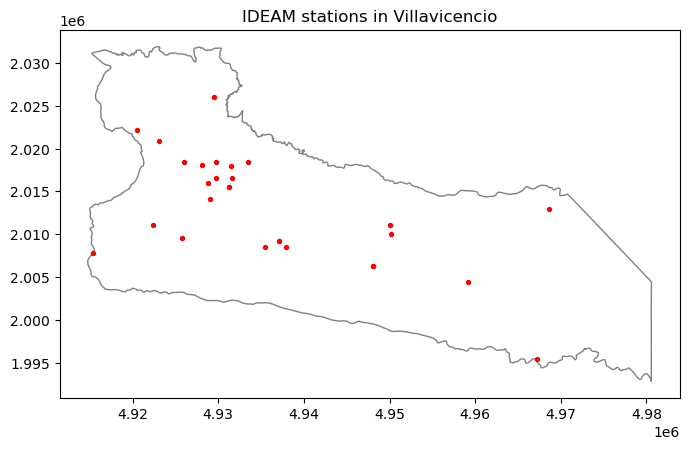

In [74]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

#villavo_roads.plot(ax=ax, color="black", linewidth=0.8)
villavo_stations.plot(ax=ax, color="red", markersize=8)
plt.title("IDEAM stations in Villavicencio")
plt.show()

#### Buffer IDEAM stations in Villavicencio

Create a buffer of 5 km

In [55]:
villavo_stations_buffer=villavo_stations.buffer(5000)

Dissolve buffers

In [56]:
villavo_stations_coverage = villavo_stations_buffer.union_all()
villavo_stations_coverage = gpd.GeoDataFrame(geometry=[villavo_stations_coverage], crs="EPSG:9377")
villavo_stations_coverage

,geometry
0,"MULTIPOLYGON (((4.97e+06 2e+06, 4.97e+06 1.99e..."


Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\3819861121.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


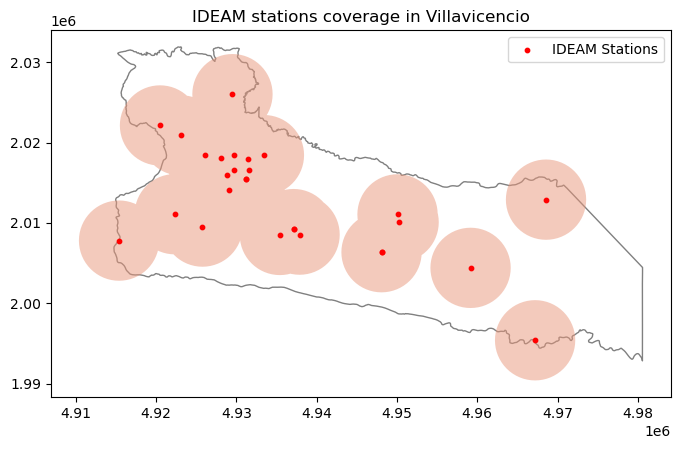

In [87]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

villavo_stations_coverage.plot(ax=ax, color="darksalmon", alpha=0.5, label='Coverage Area')
villavo_stations.plot(ax=ax, color='red', markersize=10, label='IDEAM Stations')

plt.title("IDEAM stations coverage in Villavicencio")
plt.legend()
plt.show()

#### Buffer simple drainge networks

Create buffer of 1.5 km

In [96]:
villavo_drainage_buffer=villavo_drainage.buffer(1500)

Dissolve buffers

In [97]:
villavo_drainage_buffer = villavo_drainage_buffer.union_all()
villavo_drainage_buffer = gpd.GeoDataFrame(geometry=[villavo_drainage_buffer], crs="EPSG:9377")
villavo_drainage_buffer

,geometry
0,"POLYGON ((4.95e+06 2e+06, 4.95e+06 2e+06, 4.95..."


Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\1568179352.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


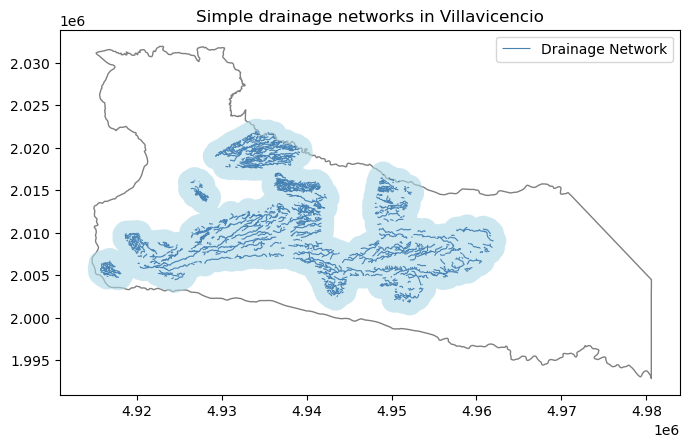

In [ ]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8), label="Villavicencio Boundary")

villavo_drainage_buffer.plot(ax=ax, color="lightblue", alpha=0.6)
villavo_drainage.plot(ax=ax, color="steelblue", linewidth=0.8, label='Drainage Network')

plt.title("Simple drainage networks in Villavicencio")
plt.legend()
plt.show()

#### Buffer roads in Villavicencio

Create buffer of 2 km

In [99]:
villavo_roads_buffer = villavo_roads.buffer(2000)
villavo_roads_buffer = villavo_roads_buffer.union_all() 
villavo_roads_buffer = gpd.GeoDataFrame(geometry=[villavo_roads_buffer], crs="EPSG:9377")
villavo_roads_buffer

,geometry
0,"MULTIPOLYGON (((4.91e+06 2.01e+06, 4.91e+06 2...."


Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\1640086213.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


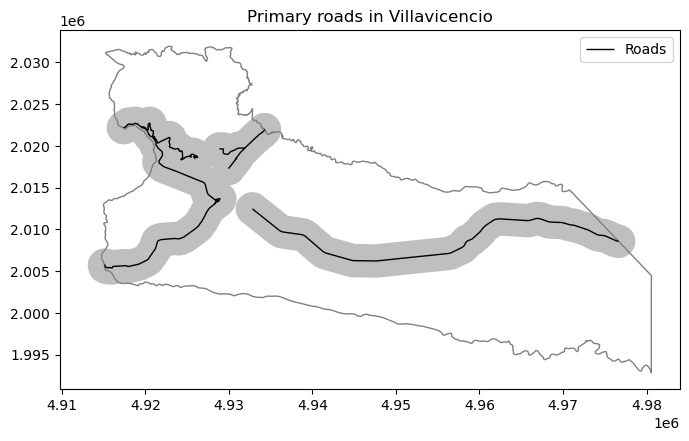

In [124]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8), label="Villavicencio Boundary")

villavo_roads_buffer.plot(ax=ax, color="gray", alpha=0.5, label="Road Buffer (1 km)")
villavo_roads.plot(ax=ax, color="black", linewidth=1, label="Roads")

plt.title("Primary roads in Villavicencio")
plt.legend()
plt.show()

#### Find candidate area

The best area to put a new IDEAM station needs to be close to a primary road, to be in an area not covered by other stations, and to not be over or too close to a drainage network. To get this, we need to intersect the buffer of the roads with the underserved areas by IDEAM. Then, we need to difference the past intersection with the buffer of the drainage networks. 

##### Find areas not covered by IDEAM stations (difference with municipality)

For this practice, it is assumed that the area outside the 5 km buffers of IDEAM stations are not covered by the meteorological institution.

Difference of `villavo_muni` with `villavo_stations_coverage`

In [103]:
underserved = villavo_muni.geometry.difference(villavo_stations_coverage, align=False)

Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\440661966.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


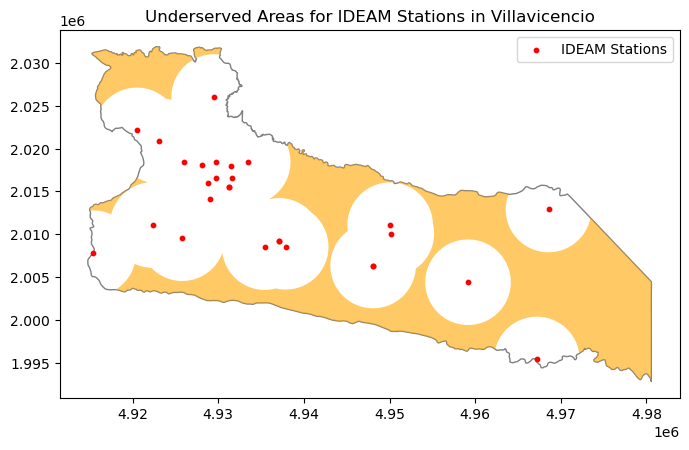

In [104]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8), label="Villavicencio Boundary")

underserved.plot(ax=ax, color="orange", alpha=0.6, label="Underserved Area")
#villavo_roads.plot(ax=ax, color="black", linewidth=0.8, label='Road')
villavo_stations.plot(ax=ax, color='red', markersize=10, label='IDEAM Stations')

plt.title("Underserved Areas for IDEAM Stations in Villavicencio")
plt.legend()
plt.show()

Intersection of `villavo_roads_buffer` with `underserved`

In [107]:
intersection = underserved.intersection(villavo_roads_buffer.unary_union)

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\894075335.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersection = underserved.intersection(villavo_roads_buffer.unary_union)


Difference of `villavo_drainage_buffer` with `intersection`

In [113]:
candidate_area = intersection.geometry.difference(villavo_drainage_buffer, align=False)

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\980215603.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


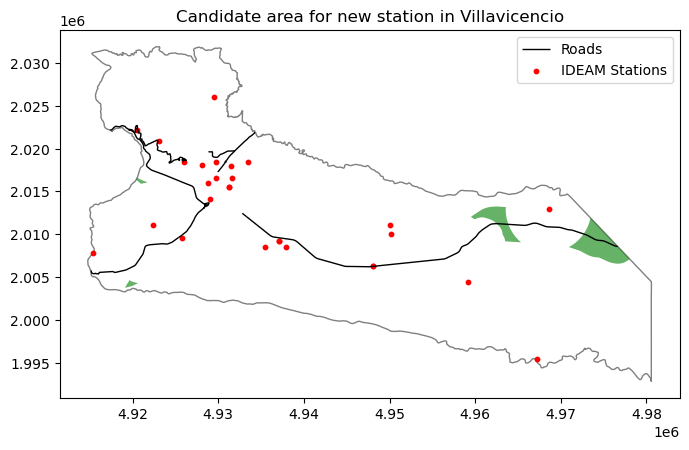

In [123]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8), label="Villavicencio Boundary")

candidate_area.plot(ax=ax, color="green", alpha=0.6, label="Underserved Area")
villavo_roads.plot(ax=ax, color="black", linewidth=1, label="Roads")
villavo_stations.plot(ax=ax, color='red', markersize=10, label='IDEAM Stations')
#villavo_stations.plot(ax=ax, color='red', markersize=10, label='IDEAM Stations')

#intersection.plot(ax=ax, color="orange", alpha=0.6, label="Underserved Area")

#villavo_drainage_buffer.plot(ax=ax, color="lightblue", alpha=0.6)
#villavo_drainage.plot(ax=ax, color="steelblue", linewidth=0.8, label='Drainage Network')


plt.title("Candidate area for new station in Villavicencio")
plt.legend()
plt.show()